In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from loaddata import *
from data.voxel_separation import *
from data.manipulate_data import *
from RTRBM.RTRBM_batches_in_funcs import RTRBM
from utils.plots import *
from utils.funcs import *
from utils.visualize_hidden_network import *

ModuleNotFoundError: No module named 'loaddata'

Import data

In [2]:
spikes, _, coords, _, _ = loaddata()

NameError: name 'loaddata' is not defined

In [3]:
data = torch.tensor(spikes)
coordinates = torch.tensor(coords)

data, coords = voxel_separation(data, coordinates, n_voxels=1000)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

nr of voxels taken: 
1000


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:29<00:00,  3.71it/s]


<AxesSubplot:>

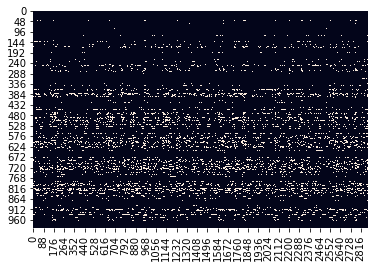

In [4]:
data = data > 0
sns.heatmap(data, cbar=False)

Train RTRBM

In [8]:
N_H = 5
rtrbm = RTRBM(data, N_H)

rtrbm.learn(n_epochs=30, spars_penalty=0.001, mom=0.2, wc=0.02)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:17<00:00,  2.57s/it]


In [1]:
rtrbm_cpu = rtrbm.cpu()

NameError: name 'rtrbm' is not defined

Calculate mean hidden receptive fields

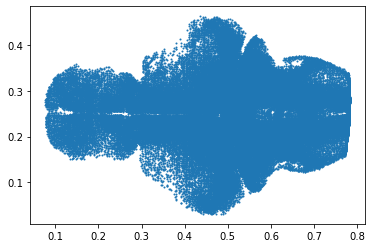

In [10]:
VH = rtrbm.W.clone()
VH[VH<0] = 0

rf = get_hidden_mean_receptive_fields(VH, coords)

plt.plot(coordinates[:,0], coordinates[:,1], '.', markersize=2)

plt.plot(rf[:,0], rf[:,1], 'o')


Plot some mock structure

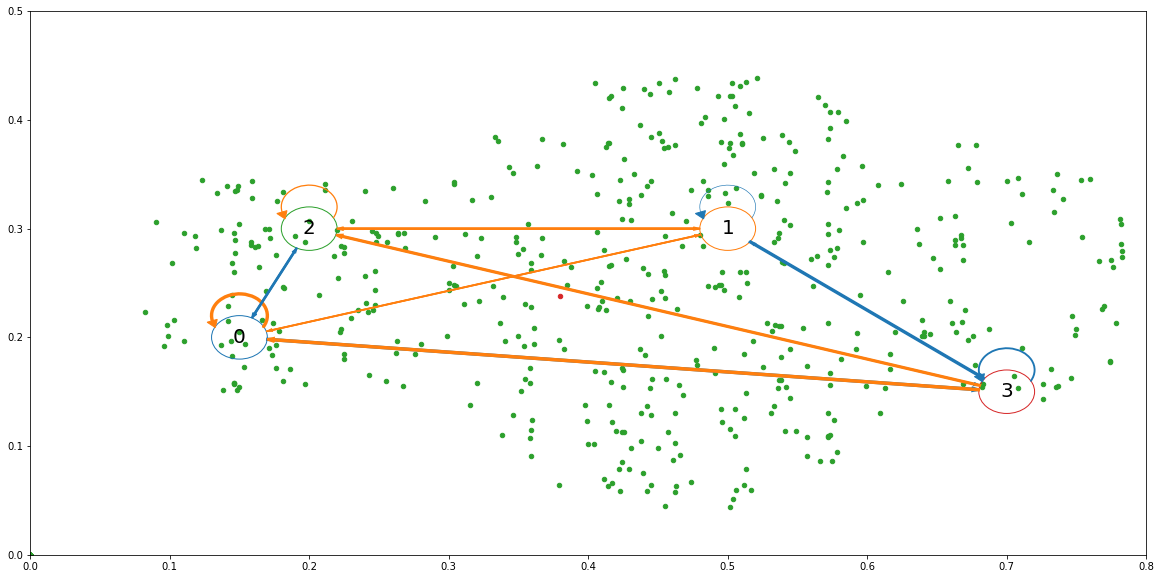

In [11]:
rf_mock = torch.tensor([[0.15, 0.2], [0.5, 0.3], [0.2, 0.3], [0.7, 0.15]])
HH_mock = 0.3*torch.randn(4,4)

create_plot(rtrbm.W, HH_mock, rf_mock, coords)

Plot RTRBM structure

In [12]:
create_plot(rtrbm.W, rtrbm.W_acc, rf, coords, hiddens_radius=0.01, weight_line_factor=0.3)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 1440x720 with 1 Axes>

Try cRBM

In [13]:
from RBMs.Codes.RBMs_works import RBMs

In [14]:
cRBM = RBMs(data.float(), N_H = 5)
cRBM = cRBM.train_cRBM(cRBM, data.float())

  5%|████                                                                              | 5/100 [00:29<09:18,  5.88s/it]


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(15,10))
plot_VH_connections(plt.gca(), torch.abs(cRBM.W.T), coords, markersize=7, strong_thresh=0.5)

In [15]:
spikes, _, coords, _, _ = loaddata()

data = torch.tensor(spikes > 0.15, dtype=torch.float32)
coordinates = torch.tensor(coords)

idx = torch.argsort(torch.mean(data,1), descending=True)

In [16]:
N_V = 5000
data_new = data[idx[:N_V],:]
coords = coords[idx[:N_V],:]

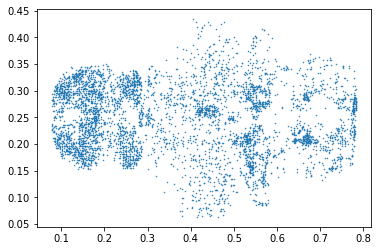

In [17]:
plt.plot(coords[:,0], coords[:,1], '.', markersize=1)

<AxesSubplot:>

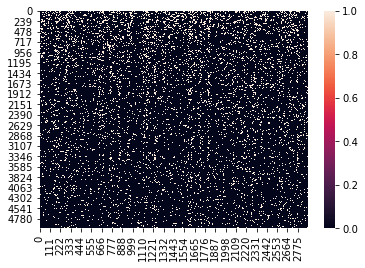

In [18]:
sns.heatmap(data_new)

In [19]:
N_H = 10

V_train, V_test = generate_train_test(data_new)

In [67]:
rtrbm = RTRBM(V_train, N_H)
rtrbm.learn(n_epochs=30, learning_rate=1e-4, mom=0.9, wc=0.0002, sp=True, batchsize=1, CDk=10, PCD=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [07:15<00:00, 14.52s/it]


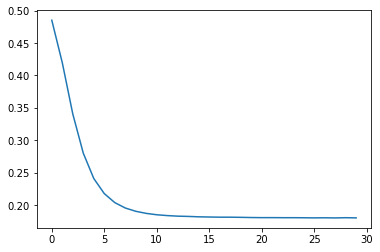

In [23]:
plt.plot(rtrbm.errors)

<AxesSubplot:>

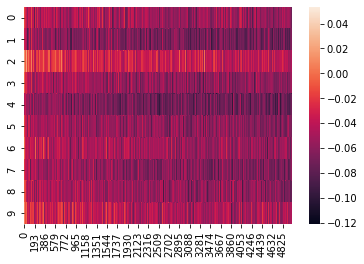

In [24]:
sns.heatmap(rtrbm.W)

In [25]:
xy = torch.tensor([coords[:,0],coords[:,1]]).T
yz = torch.tensor([coords[:,1],coords[:,2]]).T
xz = torch.tensor([coords[:,0],coords[:,2]]).T

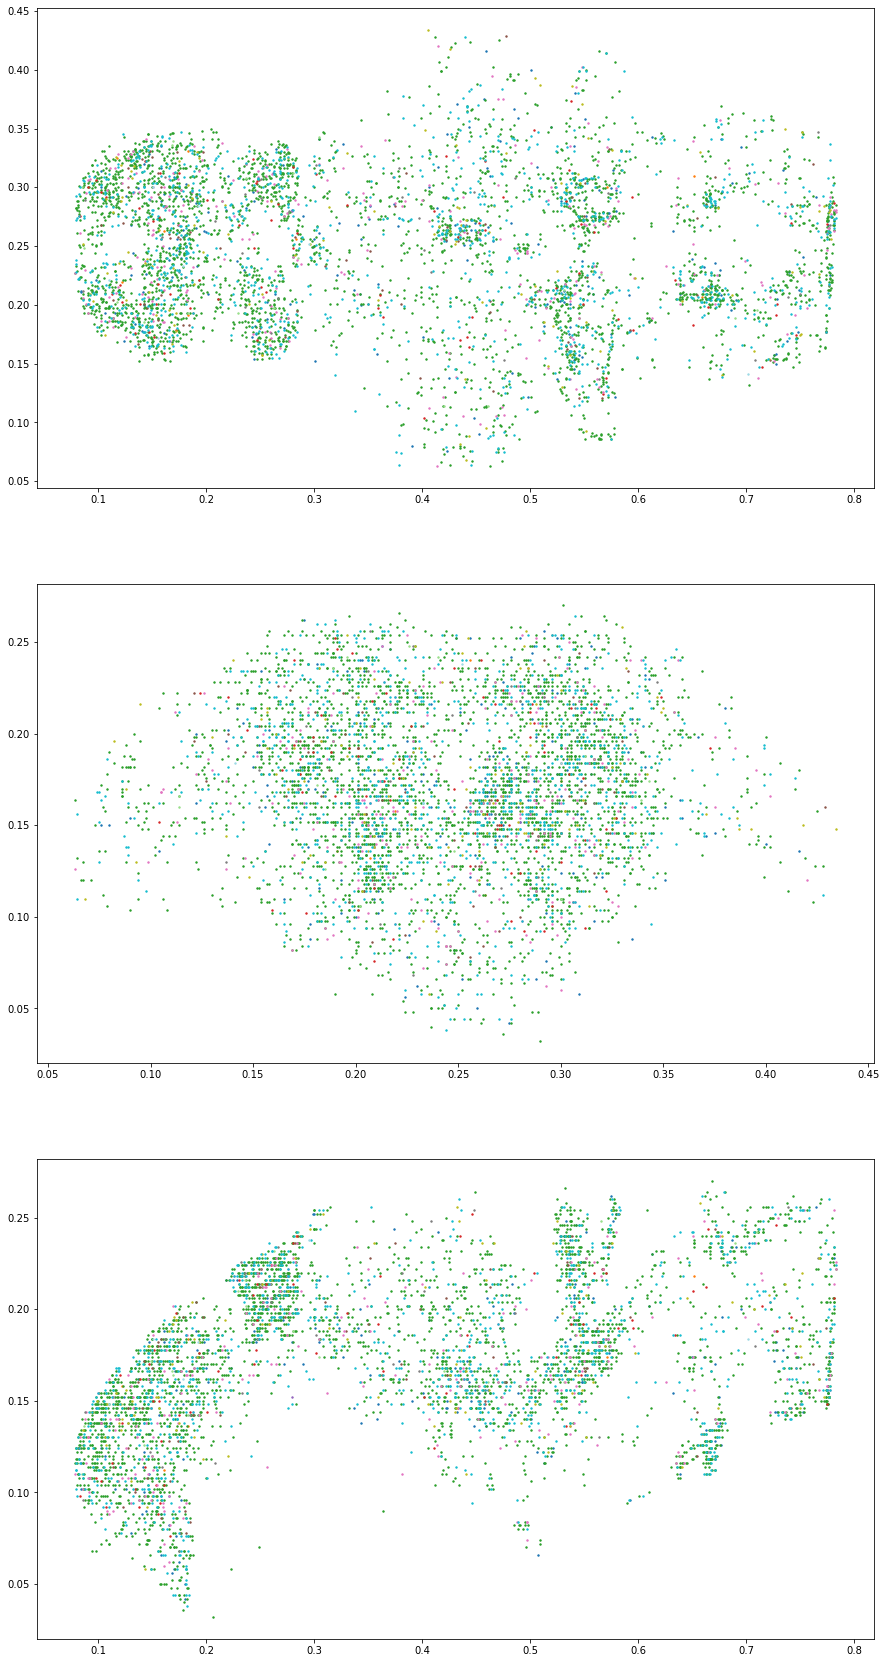

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(15,30))

plot_VH_connections(axes[0], rtrbm.W, xy, strong_thresh=0.001)
plot_VH_connections(axes[1], rtrbm.W, yz, strong_thresh=0.001)
plot_VH_connections(axes[2], rtrbm.W, xz, strong_thresh=0.001)

it seems all visibles get connected to one hidden

<AxesSubplot:>

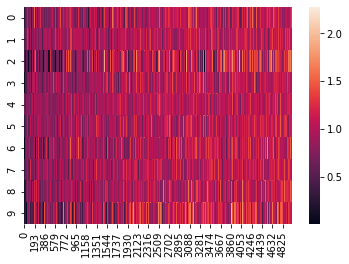

In [27]:
VH = torch.abs(rtrbm.W)

for i, h in enumerate(VH):
    h /= torch.mean(h)
    VH[i,:] = h
    
    
sns.heatmap(VH)
    

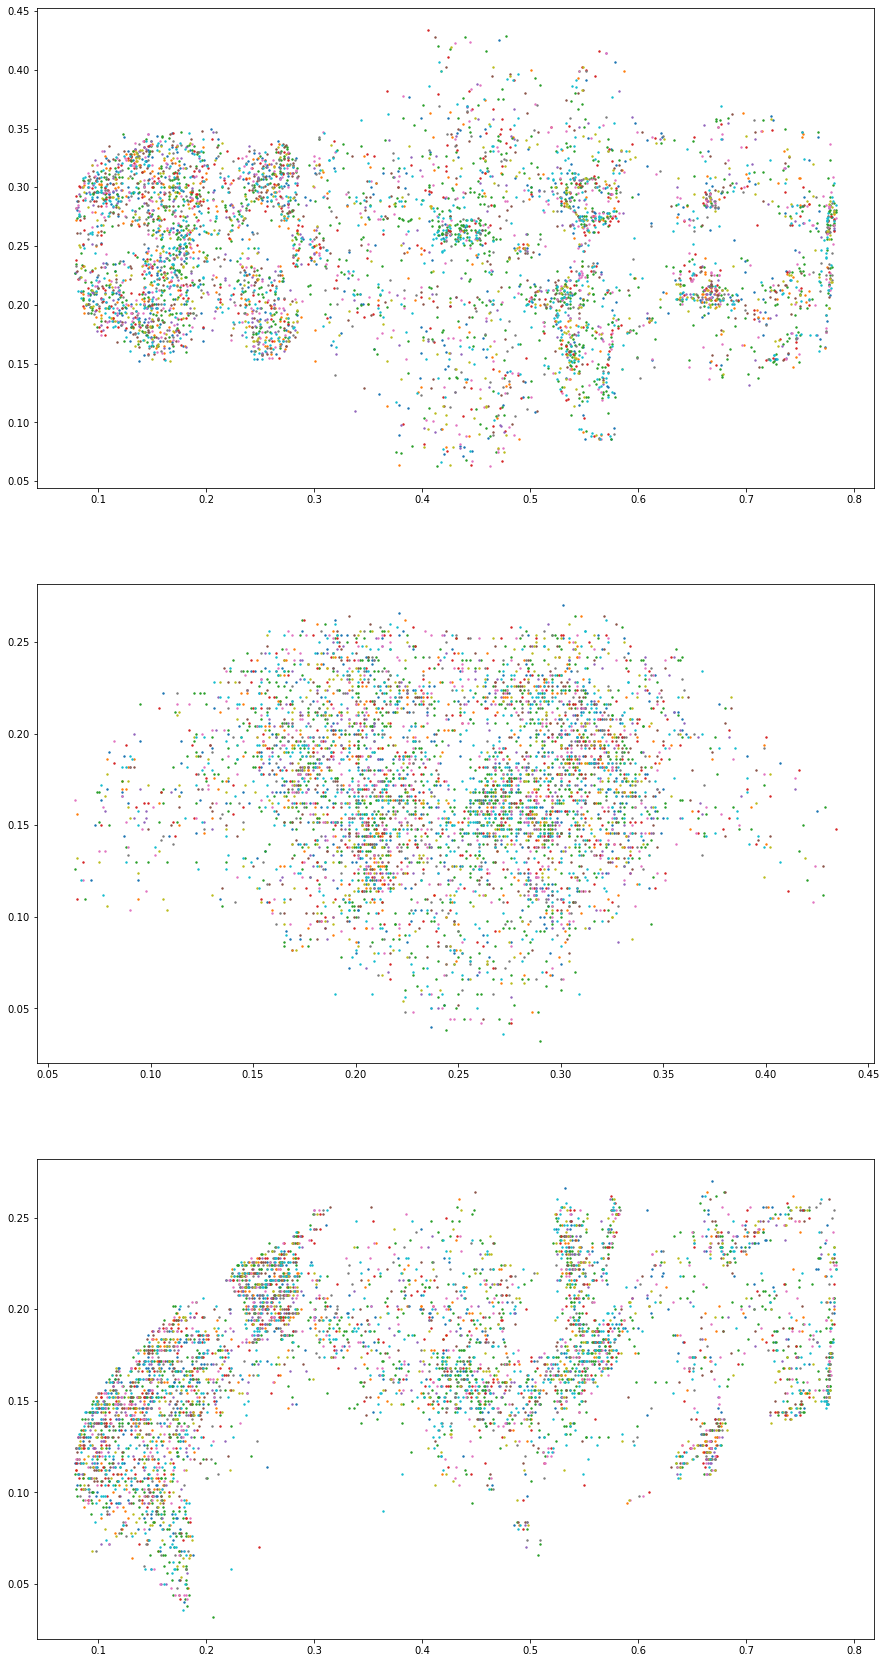

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(15,30))

plot_VH_connections(axes[0], VH, xy, strong_thresh=0.001)
plot_VH_connections(axes[1], VH, yz, strong_thresh=0.001)
plot_VH_connections(axes[2], VH, xz, strong_thresh=0.001)

In [ ]:
corr = np.corrcoef(data_new, data_new)

In [ ]:
H_data_rtrbm = rtrbm.visible_to_hidden(data_new)
H_sampled_rtrbm = rtrbm.visible_to_hidden(rtrbm.v_infer)

plot_true_sampled(data, H_data_rtrbm, rtrbm.v_infer, H_sampled_rtrbm)

In [ ]:
max_hidden_connection = torch.max(VH, 0)[1]
ax.scatter(coordinates[(max_hidden_connection==h)*(torch.abs(VH[h,:]) > strong_thresh),0], 
                   coordinates[(max_hidden_connection==h)*(torch.abs(VH[h,:]) > strong_thresh),1], 
                   color=Tableau_20.mpl_colors[(2*h) % 20], s=markersize)

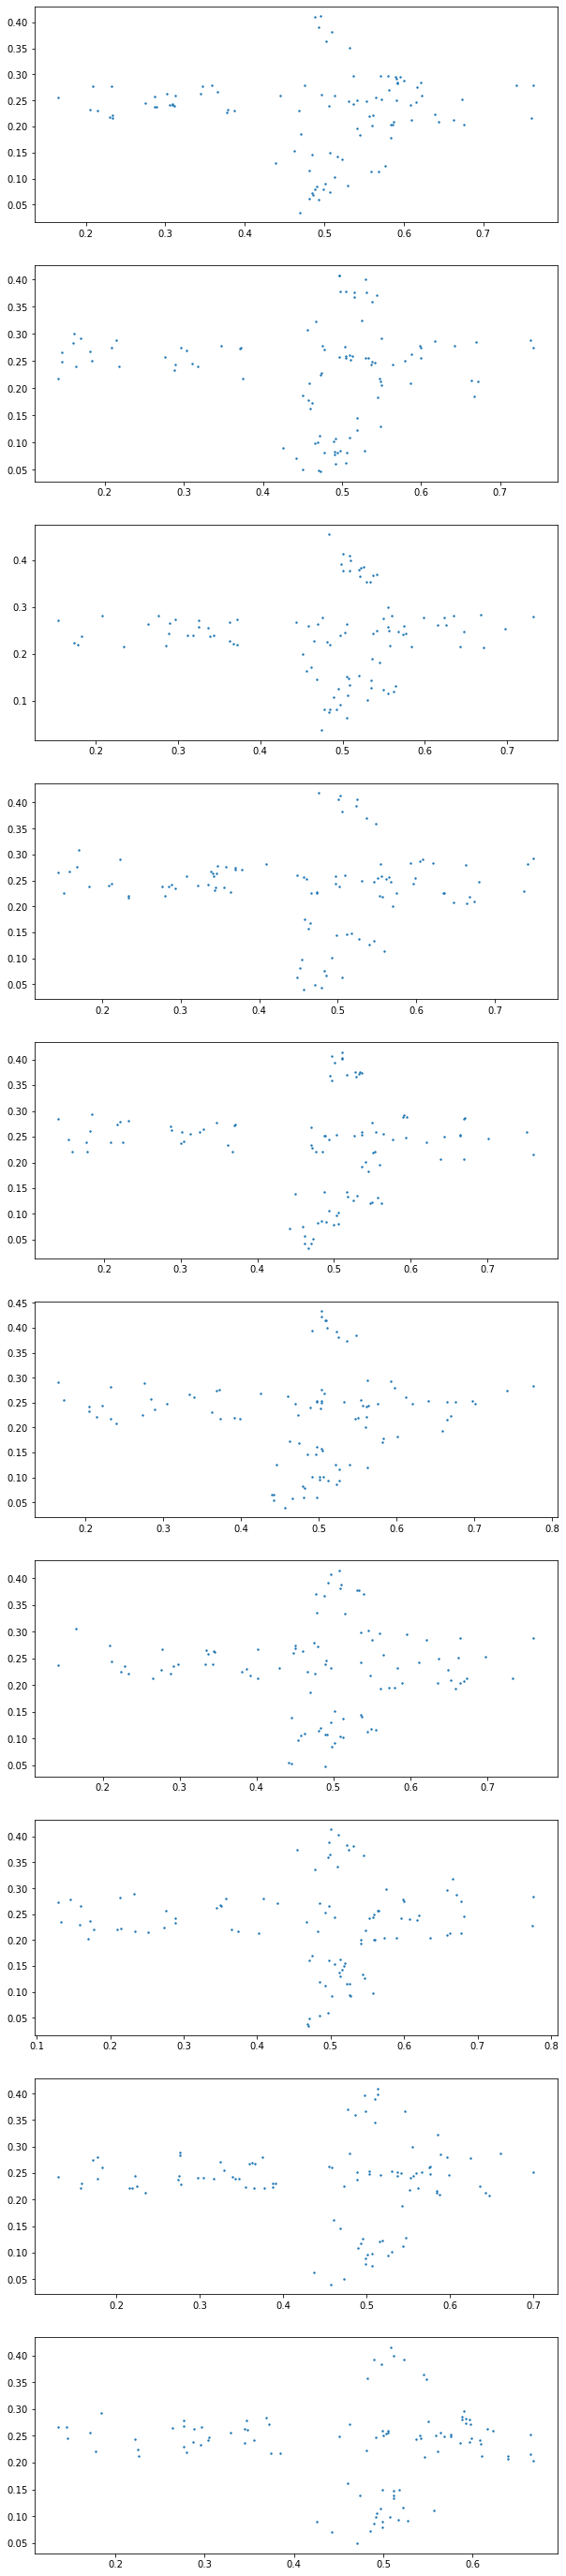

In [68]:
max_conn = 0.02


fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(10,50))
for h in range(N_H):
    ax[h].scatter(coordinates[(torch.argsort(rtrbm.W[h,:], descending=True))[:int(N_V*max_conn)], 0],
                  coordinates[(torch.argsort(rtrbm.W[h,:], descending=True))[:int(N_V*max_conn)], 1], s=2)

<AxesSubplot:>

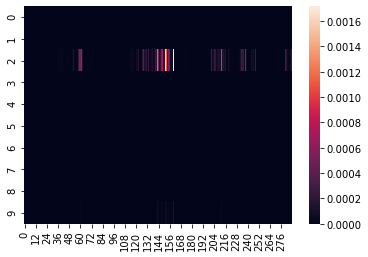

In [64]:
sns.heatmap(rtrbm.rt)